In [1]:
import csv
from tqdm import tqdm
from uszipcode import SearchEngine
import json
import matplotlib.pyplot as plt
import requests
import numpy as np
import math

zipsearch = SearchEngine(simple_zipcode=True)

In [2]:

response = requests.get("https://simplemaps.com/static/data/us-cities/uscitiesv1.4.csv")
with open("CitiesInfo.csv", 'wb') as f:
    f.write(response.content)

In [16]:
pops = []
ccount = 0
cities = []
with open("CitiesInfo.csv") as csvfile:
    reader = csv.DictReader(csvfile)
    for row in tqdm(reader):
        c = {}
#         if row["city_ascii"] == "Atlanta":
#             print(row)
#             print(row["population"])
        if row["population"] != "" and float(row["population"]) > 5000:
            c["state"] = row["state_id"]
            if c["state"] not in ["HI", "AK"]:
                c["pop"] = int(float(row["population"]))
                c["name"] = row["city_ascii"]
                c["lat"] = float(row["lat"])
                c["lng"] = float(row["lng"])
                if c["pop"] > 200000:
                    c["type"] = "city"
                    c["score"] = 0
                    ccount += 1
                else:
                    c["type"] = "hospital"
                    if c["pop"] < 10000:
                        c["score"] = 1
                    elif c["pop"] < 25000:
                        c["score"] = 2
                    elif c["pop"] < 50000:
                        c["score"] = 3
                    elif c["pop"] < 100000:
                        c["score"] = 4
                    else:
                        c["score"] = 5
                cities.append(c)
print(len(cities))
print(ccount)

36651it [00:00, 108846.19it/s]

4834
218


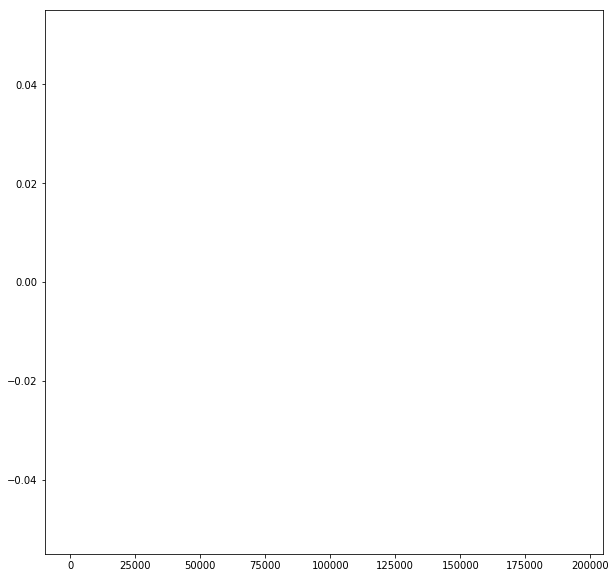

In [15]:
plt.figure(figsize=(10,10))
plt.hist(pops, bins=np.arange(0,200000,5000))
plt.show()

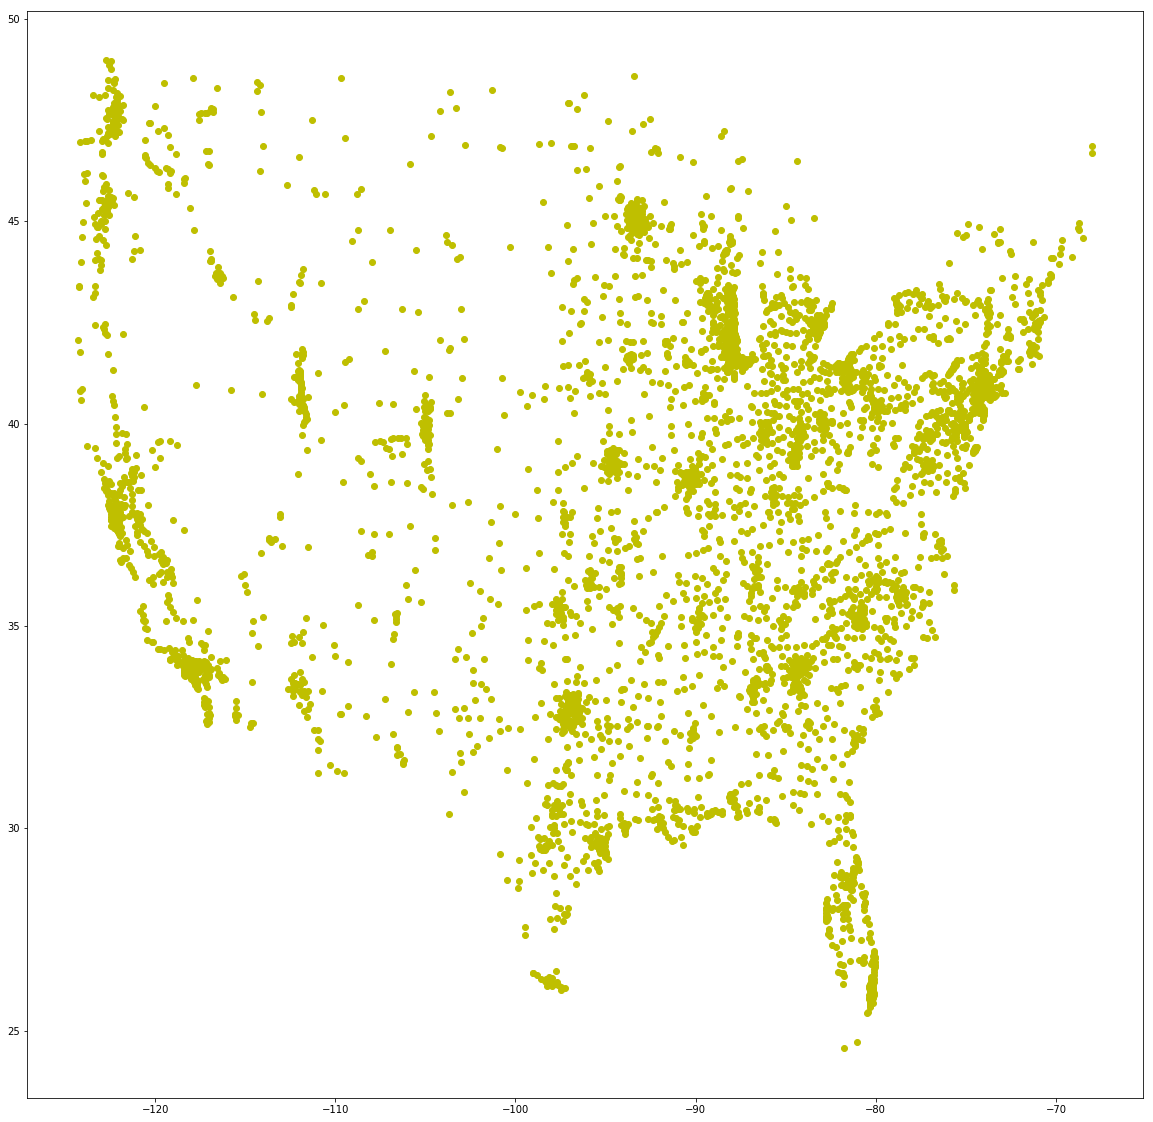

In [17]:
plt.figure(figsize=(20,20))
for c in cities:
    plt.plot(float(c["lng"]), float(c["lat"]), 'yo')
plt.show()

In [18]:
def badDistance(lat1, lng1, lat2, lng2):
    return ((lat1-lat2)**2 + (lng1-lng2)**2)**(0.5)

In [18]:
for h in tqdm(hospitals):
    nearestCity = badDistance(h["lat"], h["lng"], cities[0]["lat"], cities[0]["lng"])
    for c in cities[1:]:
        newBD = badDistance(h["lat"], h["lng"], c["lat"], c["lng"])
        if nearestCity > newBD:
            nearestCity = newBD
    h["nearestCity"] = nearestCity

100%|██████████| 4542/4542 [00:01<00:00, 3760.36it/s]


In [19]:
with open('towns.json', 'w') as outfile:
    json.dump(cities, outfile)

In [20]:
vrange = np.arange(24, 49+5, 5)
print(vrange)
hrange = np.arange(-125, -65, 5)
print(hrange)

[24 29 34 39 44 49]
[-125 -120 -115 -110 -105 -100  -95  -90  -85  -80  -75  -70]


In [21]:
chunks = [[[] for v in vrange] for h in hrange]

for c in cities:
    cx = math.floor((c["lng"]-hrange[0])/5)
    cy = math.floor((c["lat"]-vrange[0])/5)
    chunks[cx][cy].append(c)

chunkJson = {"myChunks":[]}
for i in range(len(chunks)):
    for j in range(len(chunks[0])):
        chunkJson["myChunks"].append({"name": str(i)+","+str(j), "bodies": chunks[i][j]})

In [22]:
with open('chunks2.json', 'w') as outfile:
    json.dump(chunkJson, outfile)